# Income Expenses Prediction Analysis

## Import Libraries and Load Data

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

In [2]:
df = pd.read_csv('/Users/adrianacuppuleri/Library/Mobile Documents/com~apple~CloudDocs/GITHUB ADRIANA/Financial-Behavior-Prediction/data/2016-09-19_79351_training.csv')

In [3]:
df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              408546 non-null  object 
 1   transaction_date     408546 non-null  object 
 2   transaction_type     408546 non-null  object 
 3   mcc_group            258324 non-null  float64
 4   amount_n26_currency  408546 non-null  int64  
 5   dataset_transaction  408546 non-null  object 
 6   dataset_user         408546 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.8+ MB


In [5]:
# Convert 'transaction_date' to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [6]:
df.amount_n26_currency.describe()

count    408546.000000
mean         52.764164
std         111.870681
min           3.000000
25%           7.000000
50%          17.000000
75%          38.000000
max        1166.000000
Name: amount_n26_currency, dtype: float64

## Initial Data Exploration

In [7]:
df['transaction_type'].value_counts()

transaction_type
PT     258324
CT      63837
DT      40528
DD      29869
FT       6528
DR       4727
BBU      3561
BUB       942
TUB       230
Name: count, dtype: int64

In [8]:
df['mcc_group'].value_counts(dropna=False).sort_values()
#the group with highest value counts is NaN

mcc_group
14.0        24
13.0       141
9.0        287
15.0       329
12.0       873
5.0       3337
11.0      5803
10.0      7282
7.0      10888
16.0     11150
17.0     11466
4.0      20194
8.0      20610
3.0      20875
6.0      24672
2.0      50586
1.0      69807
NaN     150222
Name: count, dtype: int64

In [9]:
#for clarity, I add a col with correspondent categories of mcc_group
mcc_group_mapping = {
    1: 'ATM',
    2: 'Groceries',
    3: 'Gastronomie',
    4: 'Shopping/(Fashion)',
    5: 'Home and DIY, House Energy',
    6: 'Travel/Hotel',
    7: 'Transport',
    8: 'Automotive/Gas',
    9: 'Family/Babies/Children',
    10: 'Entertainment/Leisure',
    11: 'Drugstore',
    12: 'Finance',
    13: 'Insurance',
    14: 'Taxes and Fines',
    15: 'Education',
    16: 'Miscellaneous',
    17: 'Business Expenses'
}

# Create a new column 'mcc_group_category' by mapping mcc_group to category name
df['mcc_group_category'] = df['mcc_group'].map(mcc_group_mapping)

# Fill in the NA values with 'NA' for missing mcc_group
#df.fillna({'mcc_group_category':'NA'}, inplace=True)

In [10]:
df[['mcc_group', 'mcc_group_category']].value_counts(dropna=False).sort_index()

mcc_group  mcc_group_category        
1.0        ATM                            69807
2.0        Groceries                      50586
3.0        Gastronomie                    20875
4.0        Shopping/(Fashion)             20194
5.0        Home and DIY, House Energy      3337
6.0        Travel/Hotel                   24672
7.0        Transport                      10888
8.0        Automotive/Gas                 20610
9.0        Family/Babies/Children           287
10.0       Entertainment/Leisure           7282
11.0       Drugstore                       5803
12.0       Finance                          873
13.0       Insurance                        141
14.0       Taxes and Fines                   24
15.0       Education                        329
16.0       Miscellaneous                  11150
17.0       Business Expenses              11466
NaN        NaN                           150222
Name: count, dtype: int64

### Data Visualization

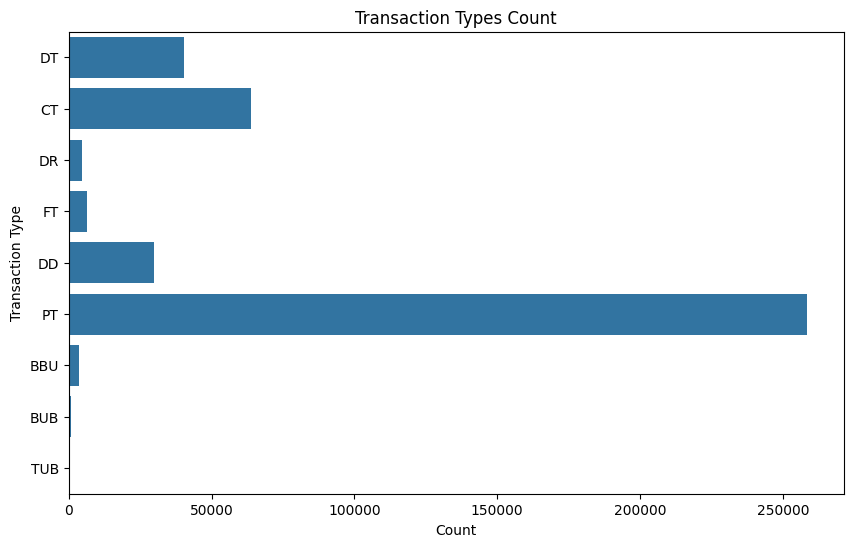

In [12]:
#the count of each transaction type
plt.figure(figsize=(10, 6))
sns.countplot(y='transaction_type', data=df)

plt.title('Transaction Types Count')
plt.xlabel('Count')
plt.ylabel('Transaction Type')
plt.show()

#PT (Presentment) has the highest count

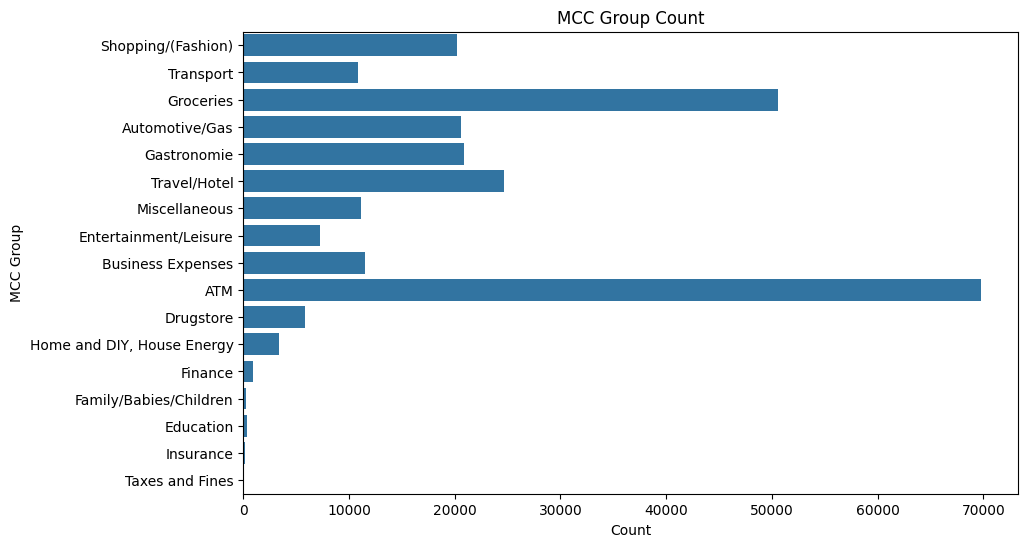

In [13]:
#the count of transactions per MCC group
plt.figure(figsize=(10, 6))
sns.countplot(y='mcc_group_category', data=df)

plt.title('MCC Group Count')
plt.xlabel('Count')
plt.ylabel('MCC Group')
plt.show()

In [14]:
#time-series exploration
# Group by month and sum the transaction amounts
monthly_transactions = df.groupby(df['transaction_date'].dt.to_period('M'))['amount_n26_currency'].sum()
monthly_transactions

transaction_date
2016-02    3118699
2016-03    3577873
2016-04    3628088
2016-05    3715338
2016-06    3710907
2016-07    3805683
Freq: M, Name: amount_n26_currency, dtype: int64

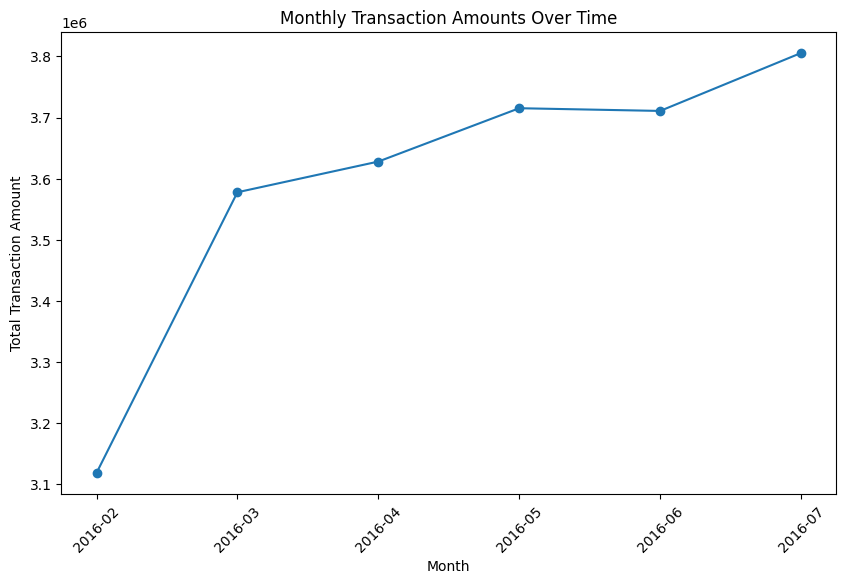

In [15]:
# Monthly aggregation by transaction amount
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_agg = df.groupby('month')['amount_n26_currency'].sum().reset_index()
monthly_agg['month'] = monthly_agg['month'].astype(str)

# Line plot of monthly aggregated transaction amounts
plt.figure(figsize=(10, 6))
plt.plot(monthly_agg['month'], monthly_agg['amount_n26_currency'], marker='o')
plt.title('Monthly Transaction Amounts Over Time')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.xticks(rotation=45)
plt.show()

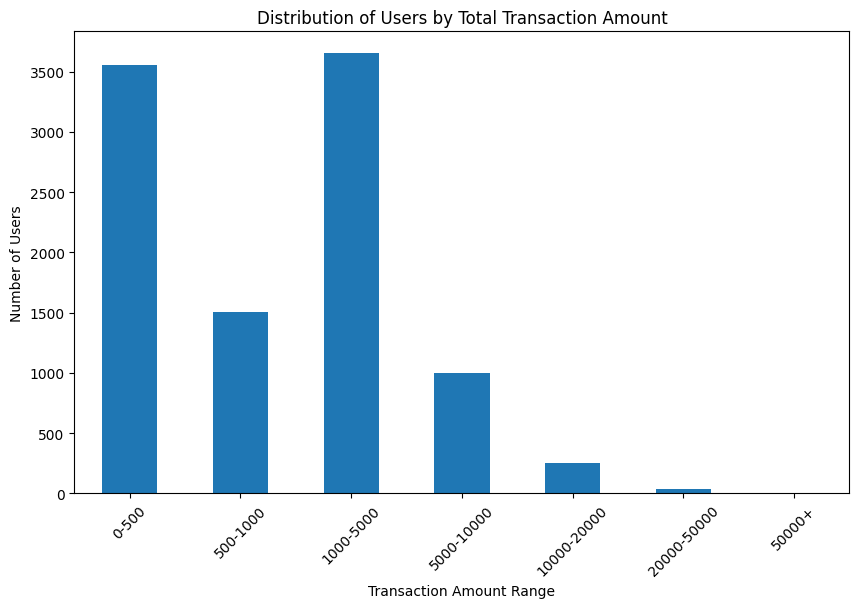

In [16]:
# Aggregate transaction amount per user and transaction groups
user_agg = df.groupby('user_id')['amount_n26_currency'].sum().reset_index()
bins = [0, 500, 1000, 5000, 10000, 20000, 50000, 100000]
labels = ['0-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-50000', '50000+']
user_agg['amount_bin'] = pd.cut(user_agg['amount_n26_currency'], bins=bins, labels=labels, include_lowest=True)
bin_counts = user_agg['amount_bin'].value_counts().sort_index()

# barplot for user-based outliers
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar')
plt.title('Distribution of Users by Total Transaction Amount')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

In [17]:
# divide transactions into expense and income
transaction_classification = {
    'PT': 'Expense',
    'DD': 'Expense',
    'DR': 'Income',
    'CT': 'Income',
    'FT': 'Expense',
    'BBU': 'Income',
    'BUB': 'Expense',
    'DT': 'Income',
    'TUB': 'Expense'
}

df['transaction_flow'] = df['transaction_type'].map(transaction_classification)

In [18]:
# Group the data by 'month' and 'transaction_flow' (Income/Expense) and sum the amounts
monthly_totals = df.groupby(['month', 'transaction_flow'])['amount_n26_currency'].sum().unstack()

# Fill any missing values with 0 (if some months don't have income or expenses)
monthly_totals.fillna(0, inplace=True)

In [19]:
monthly_totals['Income']

month
2016-02    2031898
2016-03    2280448
2016-04    2319689
2016-05    2317467
2016-06    2336558
2016-07    2365555
Freq: M, Name: Income, dtype: int64

In [20]:
monthly_totals['Expense']

month
2016-02    1086801
2016-03    1297425
2016-04    1308399
2016-05    1397871
2016-06    1374349
2016-07    1440128
Freq: M, Name: Expense, dtype: int64

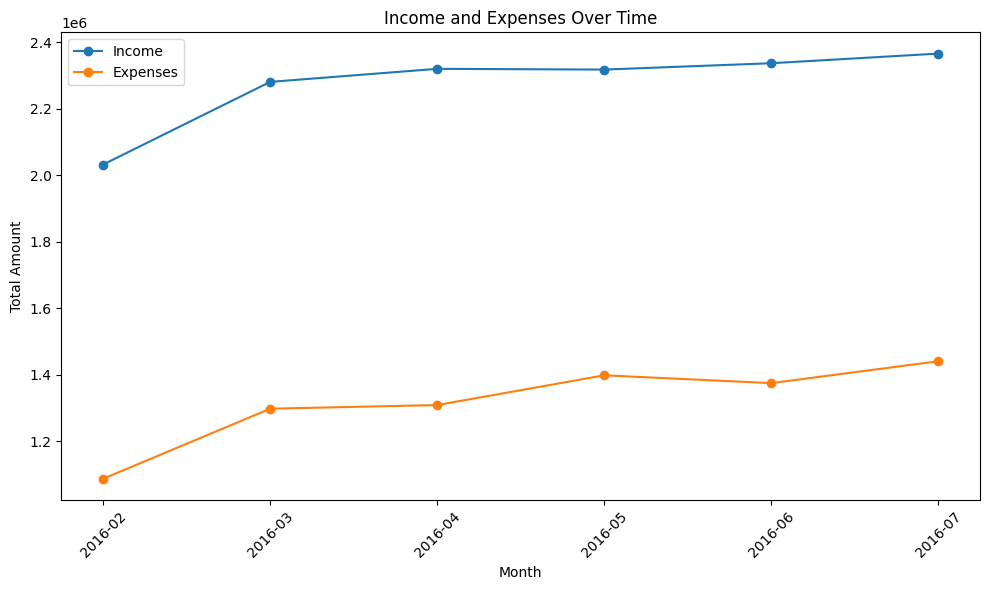

In [21]:
#  income and expenses over months
plt.figure(figsize=(10, 6))
# 
plt.plot(monthly_totals.index.astype(str), monthly_totals['Income'], label='Income', marker='o')

# Plot Expenses
plt.plot(monthly_totals.index.astype(str), monthly_totals['Expense'], label='Expenses', marker='o')

# Adding titles and labels
plt.title('Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing

### Handling Missing values and duplicates

In [22]:
print(df.isnull().sum())

user_id                     0
transaction_date            0
transaction_type            0
mcc_group              150222
amount_n26_currency         0
dataset_transaction         0
dataset_user                0
mcc_group_category     150222
month                       0
transaction_flow            0
dtype: int64


In [23]:
#Is there a relationship between the missing mcc_group values and other columns?
cross_tab = pd.crosstab(df['transaction_type'], df['mcc_group_category'])
cross_tab

mcc_group_category,ATM,Automotive/Gas,Business Expenses,Drugstore,Education,Entertainment/Leisure,Family/Babies/Children,Finance,Gastronomie,Groceries,"Home and DIY, House Energy",Insurance,Miscellaneous,Shopping/(Fashion),Taxes and Fines,Transport,Travel/Hotel
transaction_type,,,,,,,,,,,,,,,,,
PT,69807,20610,11466,5803,329,7282,287,873,20875,50586,3337,141,11150,20194,24,10888,24672


In [24]:
# Create the crosstab comparing transaction_flow with mcc_group_category
income_expense_crosstab = pd.crosstab(df['transaction_flow'], df['mcc_group_category'])
income_expense_crosstab

mcc_group_category,ATM,Automotive/Gas,Business Expenses,Drugstore,Education,Entertainment/Leisure,Family/Babies/Children,Finance,Gastronomie,Groceries,"Home and DIY, House Energy",Insurance,Miscellaneous,Shopping/(Fashion),Taxes and Fines,Transport,Travel/Hotel
transaction_flow,,,,,,,,,,,,,,,,,
Expense,69807,20610,11466,5803,329,7282,287,873,20875,50586,3337,141,11150,20194,24,10888,24672


In [25]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              408546 non-null  object        
 1   transaction_date     408546 non-null  datetime64[ns]
 2   transaction_type     408546 non-null  object        
 3   mcc_group            258324 non-null  float64       
 4   amount_n26_currency  408546 non-null  int64         
 5   dataset_transaction  408546 non-null  object        
 6   dataset_user         408546 non-null  object        
 7   mcc_group_category   258324 non-null  object        
 8   month                408546 non-null  period[M]     
 9   transaction_flow     408546 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 31.2+ MB
user_id                     0
transaction_date            0
transaction_type            0
mcc_gro

In [26]:
df[['mcc_group', 'mcc_group_category']].value_counts().sort_index()

mcc_group  mcc_group_category        
1.0        ATM                           69807
2.0        Groceries                     50586
3.0        Gastronomie                   20875
4.0        Shopping/(Fashion)            20194
5.0        Home and DIY, House Energy     3337
6.0        Travel/Hotel                  24672
7.0        Transport                     10888
8.0        Automotive/Gas                20610
9.0        Family/Babies/Children          287
10.0       Entertainment/Leisure          7282
11.0       Drugstore                      5803
12.0       Finance                         873
13.0       Insurance                       141
14.0       Taxes and Fines                  24
15.0       Education                       329
16.0       Miscellaneous                 11150
17.0       Business Expenses             11466
Name: count, dtype: int64

In [27]:
duplicates = df.duplicated()
duplicates.sum()
df[duplicates]

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,mcc_group_category,month,transaction_flow
52,d676b47c24ee99835d24e38953cf7ab6,2016-02-01,DT,NaN,15,training,training,NaN,2016-02,Income
70,ce8150cf1461297516d4f65d8258a36b,2016-02-01,DT,NaN,5,training,training,NaN,2016-02,Income
84,ce8150cf1461297516d4f65d8258a36b,2016-02-01,DT,NaN,5,training,training,NaN,2016-02,Income
93,ea589a947c4c128a6c6b81fb35605d40,2016-02-01,DT,NaN,5,training,training,NaN,2016-02,Income
102,dc879d41982dfa14abb14d96818eadd2,2016-02-01,DT,NaN,19,training,training,NaN,2016-02,Income
...,...,...,...,...,...,...,...,...,...,...
408296,dd99d81a087d354cc6131ec386800d22,2016-07-31,DT,NaN,19,training,training,NaN,2016-07,Income
408300,b6caa44ddab07f100ad5fc4927fd563e,2016-07-31,PT,1.0,19,training,training,ATM,2016-07,Expense
408307,c00d31436e6a8aabc179b8f138a3ffd4,2016-07-31,PT,1.0,194,training,training,ATM,2016-07,Expense
408493,3967d1c646a5c68aa3e64294cd77b263,2016-07-31,DT,NaN,5,training,training,NaN,2016-07,Income


In [28]:
df_cleaned = df.drop_duplicates()
df_cleaned.info()
print(df_cleaned.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 398321 entries, 0 to 408545
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              398321 non-null  object        
 1   transaction_date     398321 non-null  datetime64[ns]
 2   transaction_type     398321 non-null  object        
 3   mcc_group            251591 non-null  float64       
 4   amount_n26_currency  398321 non-null  int64         
 5   dataset_transaction  398321 non-null  object        
 6   dataset_user         398321 non-null  object        
 7   mcc_group_category   251591 non-null  object        
 8   month                398321 non-null  period[M]     
 9   transaction_flow     398321 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 33.4+ MB
user_id                     0
transaction_date            0
transaction_type            0
mcc_group   

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398321 entries, 0 to 408545
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              398321 non-null  object        
 1   transaction_date     398321 non-null  datetime64[ns]
 2   transaction_type     398321 non-null  object        
 3   mcc_group            251591 non-null  float64       
 4   amount_n26_currency  398321 non-null  int64         
 5   dataset_transaction  398321 non-null  object        
 6   dataset_user         398321 non-null  object        
 7   mcc_group_category   251591 non-null  object        
 8   month                398321 non-null  period[M]     
 9   transaction_flow     398321 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 33.4+ MB


## Further EDA

### Transaction Flow Breakdown

In [33]:
flow_counts = df['transaction_flow'].value_counts()
flow_totals = df.groupby('transaction_flow')['amount_n26_currency'].sum()

print("Transaction Flow Counts:\n", flow_counts)
print("\nTotal Income and Expense:\n", flow_totals)

Transaction Flow Counts:
 transaction_flow
Expense    295893
Income     112653
Name: count, dtype: int64

Total Income and Expense:
 transaction_flow
Expense     7904973
Income     13651615
Name: amount_n26_currency, dtype: int64


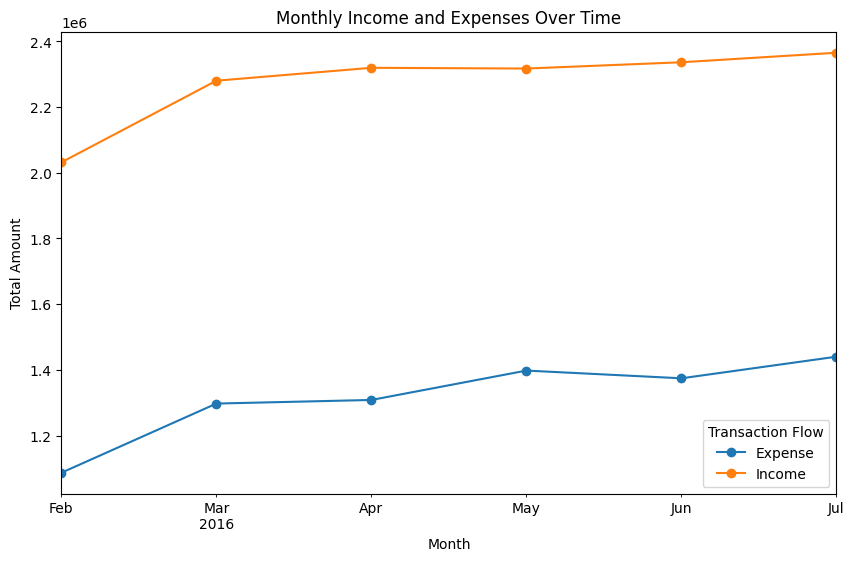

In [34]:
# Monthly flow trends
monthly_flows = df.groupby(['month', 'transaction_flow'])['amount_n26_currency'].sum().unstack()
monthly_flows.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Monthly Income and Expenses Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.legend(title='Transaction Flow')
plt.show()

In [36]:
# User-level flow summary
user_flows = df.groupby(['user_id', 'transaction_flow'])['amount_n26_currency'].sum().unstack(fill_value=0)
user_flows['net_balance'] = user_flows['Income'] - user_flows['Expense']
user_flows['net_balance'].head()


user_id
000295594379774ab9ac2c78c946d615      76
000aa792d73dd82b16a29692772d395a    1131
0011103fe4ba1264342882b7ab98c641     691
001679c77c33d7efabf800596fb2a978    4453
001e72a2f4c4376f10011735dde39cd5    -174
Name: net_balance, dtype: int64

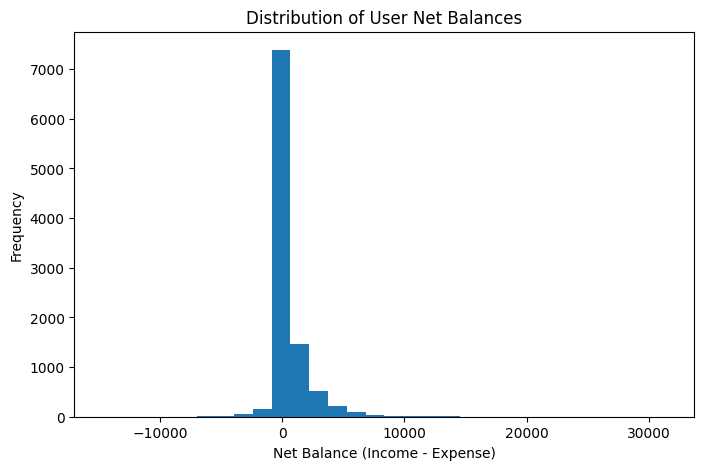

In [39]:
user_flows['net_balance'].plot(kind='hist', bins=30, figsize=(8, 5))
plt.title('Distribution of User Net Balances')
plt.xlabel('Net Balance (Income - Expense)')
plt.show()

### User-Level Aggregation

In [41]:
# Average transaction amount per user
user_avg_transaction = df.groupby('user_id')['amount_n26_currency'].mean().rename('avg_transaction_amount')
user_avg_transaction.describe()

count    10000.000000
mean        54.035757
std         60.438178
min          3.000000
25%         23.112030
50%         38.500000
75%         63.699524
max       1165.000000
Name: avg_transaction_amount, dtype: float64

In [43]:
# Total income and expenses per user
user_total_flows = df.groupby(['user_id', 'transaction_flow'])['amount_n26_currency'].sum().unstack(fill_value=0)
user_total_flows = user_total_flows.rename(columns={'Income': 'total_income', 'Expense': 'total_expense'})
user_total_flows.describe()

transaction_flow,total_expense,total_income
count,10000.000000,10000.000000
mean,790.497300,1365.161500
std,1252.053497,2108.811808
min,0.000000,0.000000
25%,84.000000,137.000000
50%,355.000000,577.500000
75%,1010.000000,1654.250000
max,22994.000000,33360.000000


In [49]:
# Number of unique transaction types per user
user_unique_types = df.groupby('user_id')['transaction_type'].nunique().rename('unique_transaction_types')
user_unique_types.describe()

count    10000.000000
mean         3.149000
std          1.419155
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
Name: unique_transaction_types, dtype: float64

In [47]:
# Monthly averages per user
monthly_user_data = df.groupby(['user_id', 'month', 'transaction_flow'])['amount_n26_currency'].sum().unstack(fill_value=0)
monthly_user_data['net_balance'] = monthly_user_data['Income'] - monthly_user_data['Expense']
user_monthly_avg = monthly_user_data.groupby('user_id').mean().rename(columns={'Income': 'avg_monthly_income', 
                                                                               'Expense': 'avg_monthly_expense', 'net_balance': 'avg_monthly_net_balance'})
user_monthly_avg.describe()

transaction_flow,avg_monthly_expense,avg_monthly_income,avg_monthly_net_balance
count,10000.000000,10000.000000,10000.000000
mean,151.083747,261.052970,109.969223
std,223.890351,365.727519,290.190597
min,0.000000,0.000000,-2907.000000
25%,25.666667,40.000000,-1.833333
50%,80.500000,128.208333,31.550000
75%,194.000000,330.000000,136.000000
max,4878.000000,5560.000000,5237.333333


In [48]:
# Combine all user-level metrics into one DataFrame
user_metrics = pd.concat([user_avg_transaction, user_total_flows, user_unique_types, user_monthly_avg], axis=1)
user_metrics.head()

,avg_transaction_amount,total_expense,total_income,unique_transaction_types,avg_monthly_expense,avg_monthly_income,avg_monthly_net_balance
user_id,,,,,,,
000295594379774ab9ac2c78c946d615,102.444444,884,960,4,176.800000,192.000000,15.200000
000aa792d73dd82b16a29692772d395a,60.840000,195,1326,4,32.500000,221.000000,188.500000
0011103fe4ba1264342882b7ab98c641,108.593750,1392,2083,3,232.000000,347.166667,115.166667
001679c77c33d7efabf800596fb2a978,138.487500,3313,7766,3,552.166667,1294.333333,742.166667
001e72a2f4c4376f10011735dde39cd5,46.636364,600,426,2,150.000000,106.500000,-43.500000


### Correlation Analysis

In [50]:
# user-level metrics
correlation_data = user_metrics[['avg_transaction_amount', 'total_income', 'total_expense', 
                                 'unique_transaction_types', 'avg_monthly_income', 
                                 'avg_monthly_expense', 'avg_monthly_net_balance']]

In [52]:
# Calculate correlation matrix
correlation_matrix = correlation_data.corr(method='pearson')
correlation_matrix

,avg_transaction_amount,total_income,total_expense,unique_transaction_types,avg_monthly_income,avg_monthly_expense,avg_monthly_net_balance
avg_transaction_amount,1.000000,0.292233,0.168910,0.000311,0.426290,0.218346,0.368793
total_income,0.292233,1.000000,0.663976,0.491226,0.964531,0.604467,0.749236
total_expense,0.168910,0.663976,1.000000,0.412498,0.623018,0.952282,0.050478
unique_transaction_types,0.000311,0.491226,0.412498,1.000000,0.449096,0.359180,0.288878
avg_monthly_income,0.426290,0.964531,0.623018,0.449096,1.000000,0.608631,0.790725
avg_monthly_expense,0.218346,0.604467,0.952282,0.359180,0.608631,1.000000,-0.004470
avg_monthly_net_balance,0.368793,0.749236,0.050478,0.288878,0.790725,-0.004470,1.000000


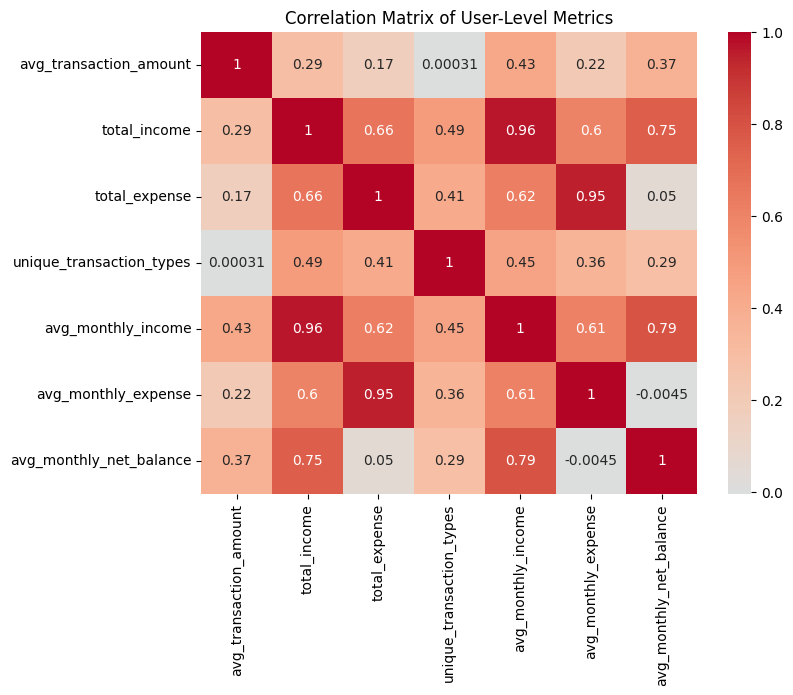

In [55]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of User-Level Metrics")
plt.show()

### Anomalies and Outliers

In [56]:
# IQR in total income
Q1 = user_metrics['total_income'].quantile(0.25)
Q3 = user_metrics['total_income'].quantile(0.75)
IQR = Q3 - Q1
income_outliers = user_metrics[(user_metrics['total_income'] < (Q1 - 1.5 * IQR)) | (user_metrics['total_income'] > (Q3 + 1.5 * IQR))]
income_outliers

,avg_transaction_amount,total_expense,total_income,unique_transaction_types,avg_monthly_expense,avg_monthly_income,avg_monthly_net_balance
user_id,,,,,,,
001679c77c33d7efabf800596fb2a978,138.487500,3313,7766,3,552.166667,1294.333333,742.166667
003b0bcbafbaf5971027f95d1d084e77,221.625000,2422,11762,4,403.666667,1960.333333,1556.666667
0082dace2f94dbb8a336cd15554005f6,51.923664,1272,5530,6,212.000000,921.666667,709.666667
00e07dbe5c541ee1ab4f65ea0cd52b45,127.242857,2783,6124,5,463.833333,1020.666667,556.833333
00fcebdad3faf9f3f1a07644bec9c7cc,32.575875,3227,5145,5,537.833333,857.500000,319.666667
...,...,...,...,...,...,...,...
ff22282f91da101666ba90453cb26306,73.164948,2343,4754,5,390.500000,792.333333,401.833333
ff34943663f863e056660fdf474ee705,54.575758,2808,4396,6,468.000000,732.666667,264.666667
ffb0b1b4d39830aabc41f451603d64ff,53.428571,1044,4192,7,174.000000,698.666667,524.666667


In [59]:
# Z-score in total expense
user_metrics['expense_z_score'] = (user_metrics['total_expense'] - user_metrics['total_expense'].mean()) / user_metrics['total_expense'].std()
expense_outliers = user_metrics[np.abs(user_metrics['expense_z_score']) > 3]
expense_outliers

,avg_transaction_amount,total_expense,total_income,unique_transaction_types,avg_monthly_expense,avg_monthly_income,avg_monthly_net_balance,expense_z_score
user_id,,,,,,,,
034ce803dfa50ba1af4673da7bbef67a,47.608696,4550,4210,5,758.333333,701.666667,-56.666667,3.002669
03dd44414883742d3cee03dd8fe4938f,118.463768,5829,10519,5,971.500000,1753.166667,781.666667,4.024191
03e14ca2ea8a6fe54d8ce70b4515fd41,47.175497,10840,3407,6,1806.666667,567.833333,-1238.833333,8.026416
081749e375e28916d8b4650c31576ed3,77.065574,6146,7957,3,1024.333333,1326.166667,301.833333,4.277375
099bd270637e5ffa6c6a3e754567af93,52.792763,6953,9096,6,1158.833333,1516.000000,357.166667,4.921916
...,...,...,...,...,...,...,...,...
fb91d41fd0571fd22ca35acbc0d42321,81.015267,5259,5354,3,876.500000,892.333333,15.833333,3.568939
fc11a8cd56be5e0c488066229ab48ebc,57.773196,4951,6257,5,825.166667,1042.833333,217.666667,3.322943
fcae24dd9dfb932312622eece8b4c311,64.012698,10227,9937,6,1704.500000,1656.166667,-48.333333,7.536821


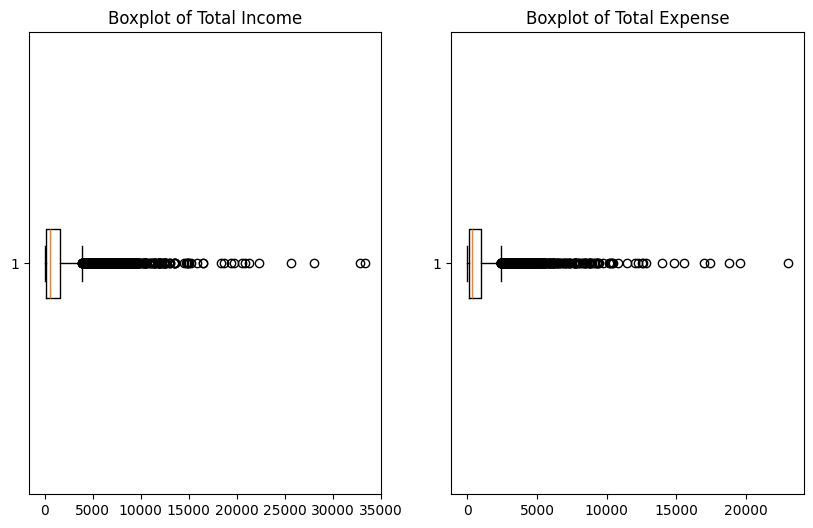

In [60]:
# boxplot for total income and total expense
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(user_metrics['total_income'], vert=False)
plt.title('Boxplot of Total Income')

plt.subplot(1, 2, 2)
plt.boxplot(user_metrics['total_expense'], vert=False)
plt.title('Boxplot of Total Expense')
plt.show()

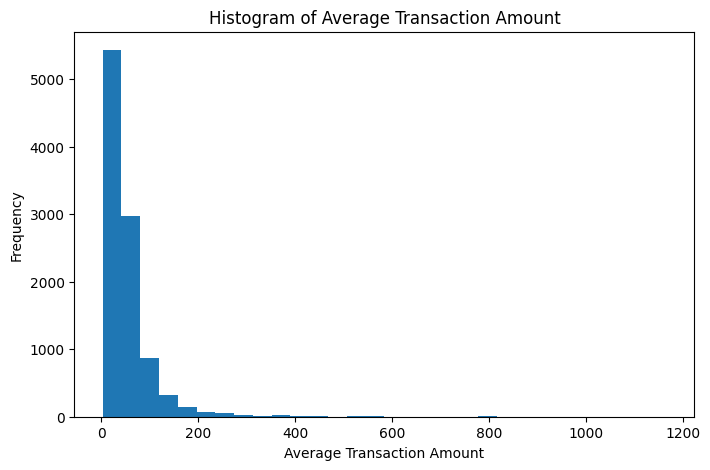

In [61]:
# Plot histogram of average transaction amount
plt.figure(figsize=(8, 5))
plt.hist(user_metrics['avg_transaction_amount'], bins=30)
plt.title('Histogram of Average Transaction Amount')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

### Trend Comparison between Transaction Categories 

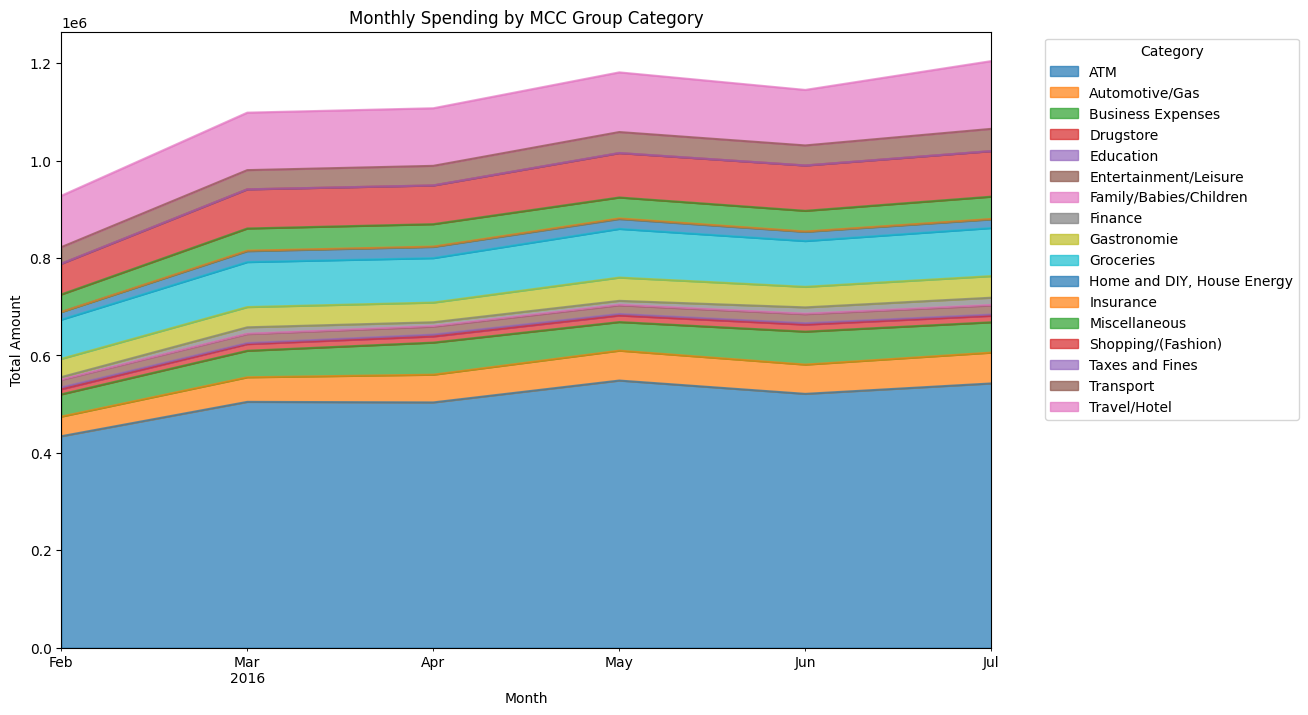

In [63]:
# Monthly spending by category
monthly_category_spending = df[df['transaction_type'] == 'PT'].groupby(['month', 'mcc_group_category'])['amount_n26_currency'].sum().unstack()
monthly_category_spending.plot(kind='area', stacked=True, figsize=(12, 8), alpha=0.7)
plt.title('Monthly Spending by MCC Group Category')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

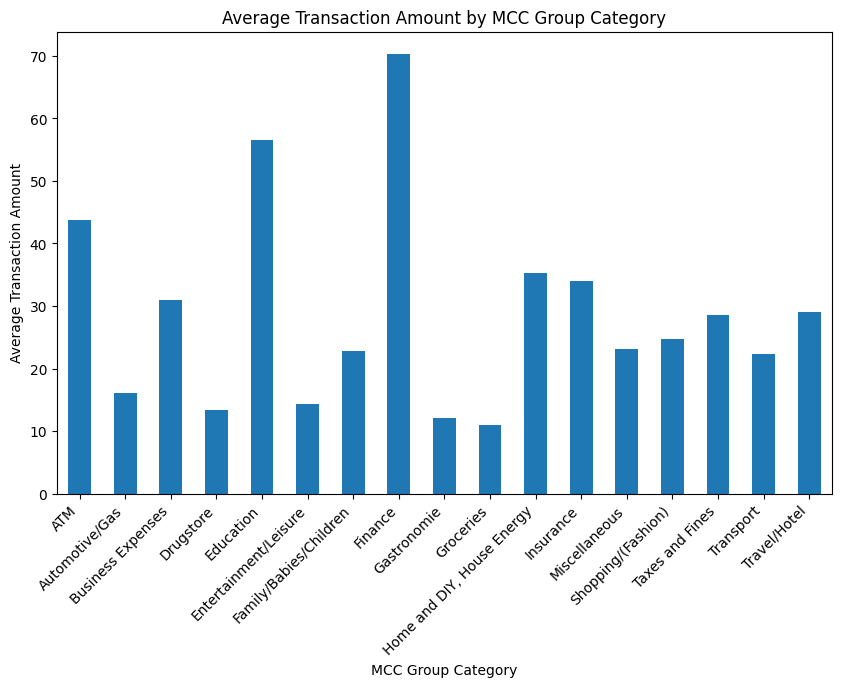

In [70]:
# Average transaction amount by category
avg_transaction_category = df[df['transaction_type'] == 'PT'].groupby('mcc_group_category')['amount_n26_currency'].mean()
avg_transaction_category.plot(kind='bar', figsize=(10, 6))
plt.title('Average Transaction Amount by MCC Group Category')
plt.xlabel('MCC Group Category')
plt.ylabel('Average Transaction Amount')
plt.xticks(rotation=45, ha='right')
plt.show()

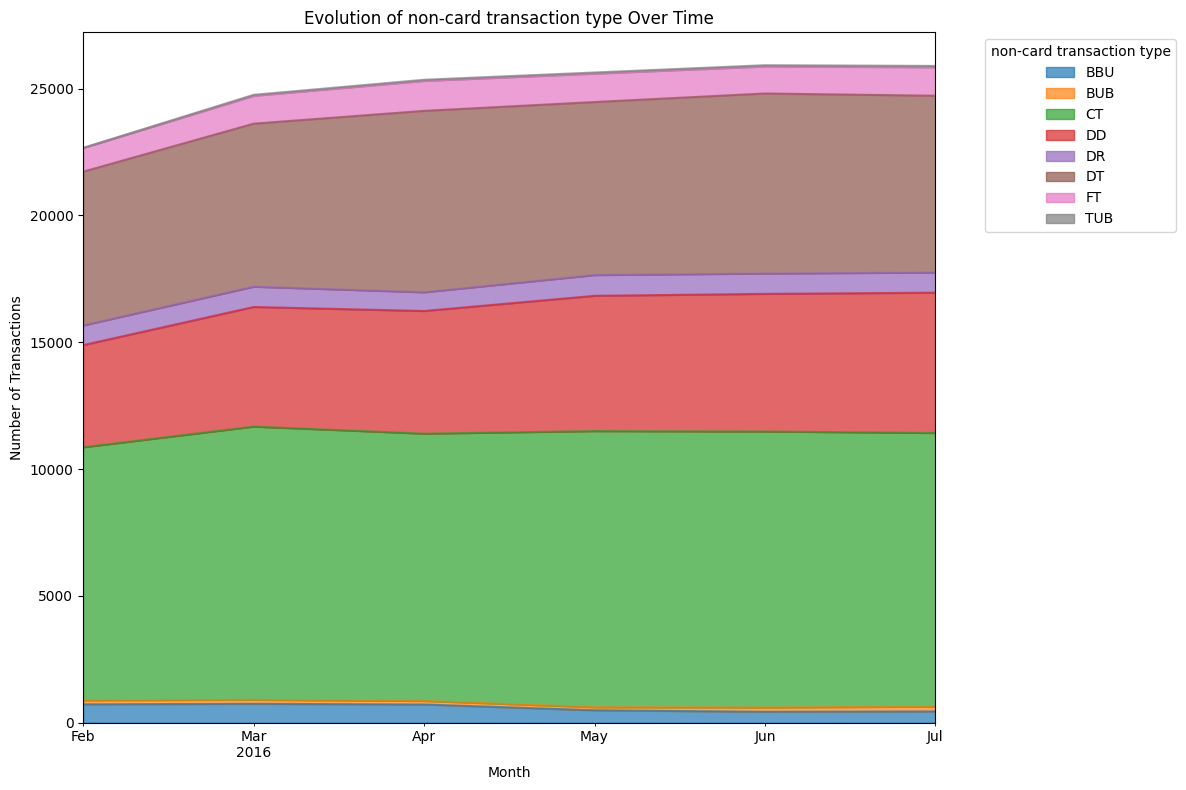

In [32]:
monthly_transaction_type_counts = df.groupby(['month', 'transaction_type']).size().unstack(fill_value=0)
monthly_transaction_type_counts = monthly_transaction_type_counts.drop(columns=['PT'], errors='ignore')

# Plot the area chart with remaining categories
monthly_transaction_type_counts.plot(kind='area', stacked=True, figsize=(12, 8), alpha=0.7)

plt.title('Evolution of non-card transaction type Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='non-card transaction type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [74]:
# User-level category spending patterns (only users who did perform a PT transaction)
user_category_spending = df[df['transaction_type'] == 'PT'].groupby(['user_id', 'mcc_group_category'])['amount_n26_currency'].sum().unstack(fill_value=0)
user_category_spending = user_category_spending.div(user_category_spending.sum(axis=1), axis=0) * 100  # Convert to percentage
user_category_spending.describe()

mcc_group_category,ATM,Automotive/Gas,Business Expenses,Drugstore,Education,Entertainment/Leisure,Family/Babies/Children,Finance,Gastronomie,Groceries,"Home and DIY, House Energy",Insurance,Miscellaneous,Shopping/(Fashion),Taxes and Fines,Transport,Travel/Hotel
count,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000
mean,38.995842,5.888577,5.529671,1.277833,0.226918,2.504976,0.115339,0.723727,4.484838,10.450917,1.480979,0.051181,5.258746,8.382171,0.016578,3.912072,10.699635
std,33.686492,13.625361,13.575713,4.998248,3.046427,10.327134,1.679493,6.553335,11.157202,17.304674,6.418078,0.847104,15.060281,15.674625,1.002745,11.539489,19.533445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.070175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.075461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.429355,0.000000,0.000000,0.000000,1.774820,0.000000,0.000000,1.960784
75%,66.035183,5.590062,4.672897,0.356506,0.000000,0.434405,0.000000,0.000000,3.983051,13.319386,0.000000,0.000000,3.099593,10.022779,0.000000,2.352941,12.076271
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,45.070423,100.000000,100.000000,93.750000,100.000000,100.000000
